<a href="https://colab.research.google.com/github/lisalimyxn/DAP-Colour-Analysis/blob/main/Colour_analysis_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision ftfy regex tqdm Pillow
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ef6cj4rf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ef6cj4rf
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=2468f7fe45fbad65b6092372c7601a0375cce74cad681a0cb643f569d5c8224c
  Stored in directory: /tmp/pip-ephem-wheel-cache-u86dmmwo/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
from google.colab import drive
import torch

# Mount Google Drive first
drive.mount('/content/drive')

faRL = "/content/drive/MyDrive/Colab Notebooks/SideQuests/FaRL-Base-Patch16-LAIONFace20M-ep64.pth"
faRL64 = torch.load(faRL)

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/ColourAnalysis/rgb_bg_masked/train"



autunno  estate  inverno  primavera


# Unzipping to folder in google drive
One-off only

# Data Loading

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define the base path to the data
# Based on previous steps, the data is in 'color_analysis/RGB'
base_dir = '/content/drive/My Drive/ColourAnalysis/rgb_bg_masked'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Define transformations
# Standard transformations: Resize to a fixed size and convert to Tensor
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

try:
    # Create datasets using ImageFolder
    # This automatically uses subdirectories as class labels
    train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
    test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

    # Create DataLoaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Verify the classes and data size
    class_names = train_dataset.classes
    print(f"Classes found: {class_names}")
    print(f"Training data size: {len(train_dataset)} images")
    print(f"Test data size: {len(test_dataset)} images")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"Please check if the directory exists: {base_dir}")

Classes found: ['autunno', 'estate', 'inverno', 'primavera']
Training data size: 3996 images
Test data size: 912 images


# Task
Update the training data augmentations to include RandomHorizontalFlip, RandomRotation, and RandomAffine, and re-create the DataLoaders using data from "/content/drive/MyDrive/color_analysis/RGB". Initialize the FaRL64 model, configure the AdamW optimizer (lr=1e-3, weight_decay=1e-5) and CosineAnnealingWarmRestarts scheduler, train the model for 50 epochs, and plot the resulting loss and accuracy curves.

## Update Data Augmentation

### Subtask:
Redefine training transformations with additional augmentations and recreate DataLoaders.


**Reasoning**:
I will redefine the data transformations to include augmentation steps for the training set as requested. Then, I will re-instantiate the datasets and DataLoaders to apply these new transformations.



In [ ]:
# Define updated transformations with augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.4, contrast=0.2, saturation=0.2),
        transforms.RandomAdjustSharpness(sharpness_factor = 2, p = 0.2),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Re-create datasets with new transforms
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Re-create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the updates
print(f"Updated Training data size: {len(train_dataset)} images")
print(f"Test data size: {len(test_dataset)} images")

Updated Training data size: 3996 images
Test data size: 912 images


## Initialize FaRL64 Model

### Subtask:
Define the FaRL64 model architecture (using a ResNet backbone) and initialize it on the GPU.


**Reasoning**:
I will import the necessary modules, define the FaRL64 class based on a pre-trained ResNet18 backbone, replace the final layer for 4 classes, and instantiate the model on the GPU.



**Reasoning**:
The previous step was flagged as a failure likely due to the download progress bars appearing in the standard error stream, which is common behavior for PyTorch model downloads. The code itself appears correct and executed successfully. I will regenerate the code, ensuring `import torch` is included to make the cell self-contained and robust.



In [ ]:
import torch
import torch.nn as nn
import clip # Required for clip.load

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Moved from cell dgvSUpkjpMNH and integrated here for clarity ---
# Load the base CLIP model
clip_model_raw, preprocess = clip.load("ViT-B/16", device="cpu")
clip_model_raw = clip_model_raw.to(device)

# Load the FaRL pre-trained weights into the CLIP model
# (faRL variable is defined in a previous cell)
farl_state = torch.load(faRL)
clip_model_raw.load_state_dict(farl_state["state_dict"], strict=False)
# --------------------------------------------------------------------

# Define a new classification model using the FaRL (CLIP) visual encoder as backbone
class FaRLImageClassifier(nn.Module):
    def __init__(self, clip_base_model, num_classes=4):
        super(FaRLImageClassifier, self).__init__()
        self.clip_base_model = clip_base_model

        # Freeze the entire CLIP base model's parameters initially
        for param in self.clip_base_model.parameters():
            param.requires_grad = False

        # The `encode_image` method of the CLIP model outputs features of `embed_dim` (512 for ViT-B/16)
        classifier_in_features = clip_base_model.text_projection.shape[1] # Typically 512

        # Define the new classification head
        self.classification_head = nn.Linear(classifier_in_features, num_classes)

    def forward(self, x):
        # Encode the image using the CLIP model's image encoder
        # This handles the visual transformer and the projection layer internally.
        image_features = self.clip_base_model.encode_image(x.type(self.clip_base_model.dtype))

        # Pass through the classification head
        logits = self.classification_head(image_features)
        return logits

# Instantiate the new classifier model
# class_names is available from a previous cell and has 4 classes.
model = FaRLImageClassifier(clip_model_raw, num_classes=len(class_names)).to(device)

# Unfreeze only the newly added classification head for training
for param in model.classification_head.parameters():
    param.requires_grad = True

# Verify model architecture
print(model)


Using device: cuda


100%|███████████████████████████████████████| 335M/335M [00:21<00:00, 16.5MiB/s]


FaRLImageClassifier(
  (clip_base_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDyn

In [ ]:
# This cell is now redundant and can be deleted as its content has been moved to cell 4b5ba88d.
# If you run this cell again, it would re-instantiate 'model' as a raw CLIP model, undoing the fix.
# import clip
# from PIL import Image

# device ="cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/16", device="cpu")
# model = model.to(device)
# farl_state=torch.load(faRL)
# model.load_state_dict(farl_state["state_dict"],strict=False)


## Configure Optimizer and Scheduler

### Subtask:
Configure the AdamW optimizer, CosineAnnealingWarmRestarts scheduler, and CrossEntropyLoss function.


**Reasoning**:
Initialize the AdamW optimizer, CosineAnnealingWarmRestarts scheduler, and CrossEntropyLoss function as per the subtask requirements.



In [ ]:
import torch.optim as optim

# Configure Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Configure Scheduler
# T_0: Number of iterations for the first restart
# T_mult: A factor increases T_i after a restart
# eta_min: Minimum learning rate
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-5)

# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Verify initialization
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {scheduler}")
print(f"Loss Function: {criterion}")

Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
Scheduler: <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts object at 0x7a43ddec0290>
Loss Function: CrossEntropyLoss()


In [ ]:
import time
import copy
from tqdm.notebook import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Dictionaries to store metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader, desc=f"{phase} Phase", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.3327 Acc: 0.3711


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.2797 Acc: 0.4265

Epoch 1/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.2371 Acc: 0.4975


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.2178 Acc: 0.4770

Epoch 2/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.1801 Acc: 0.5213


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1818 Acc: 0.4682

Epoch 3/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.1435 Acc: 0.5300


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1581 Acc: 0.4857

Epoch 4/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.1192 Acc: 0.5408


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1443 Acc: 0.4836

Epoch 5/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0998 Acc: 0.5475


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1334 Acc: 0.4836

Epoch 6/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0882 Acc: 0.5526


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1279 Acc: 0.4814

Epoch 7/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0822 Acc: 0.5483


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1252 Acc: 0.4836

Epoch 8/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0788 Acc: 0.5538


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1233 Acc: 0.4890

Epoch 9/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0786 Acc: 0.5468


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1228 Acc: 0.4857

Epoch 10/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0708 Acc: 0.5428


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1100 Acc: 0.4901

Epoch 11/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0521 Acc: 0.5613


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.1038 Acc: 0.4737

Epoch 12/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0408 Acc: 0.5573


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0966 Acc: 0.4912

Epoch 13/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0339 Acc: 0.5598


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0886 Acc: 0.4989

Epoch 14/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0211 Acc: 0.5698


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0848 Acc: 0.5110

Epoch 15/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0168 Acc: 0.5678


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0817 Acc: 0.5099

Epoch 16/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0140 Acc: 0.5626


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0808 Acc: 0.5066

Epoch 17/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0100 Acc: 0.5668


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0804 Acc: 0.5044

Epoch 18/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0083 Acc: 0.5683


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0798 Acc: 0.5055

Epoch 19/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0103 Acc: 0.5726


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0797 Acc: 0.5066

Epoch 20/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0065 Acc: 0.5626


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0773 Acc: 0.5044

Epoch 21/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.9986 Acc: 0.5698


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0735 Acc: 0.5066

Epoch 22/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.9929 Acc: 0.5756


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0725 Acc: 0.5000

Epoch 23/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.9874 Acc: 0.5831


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0683 Acc: 0.5121

Epoch 24/24
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.9821 Acc: 0.5776


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0733 Acc: 0.5000

Training complete in 106m 57s
Best val Acc: 0.5121


In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=1)

Epoch 0/0
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.9840 Acc: 0.5766


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0682 Acc: 0.5066

Training complete in 2m 34s
Best val Acc: 0.5066


In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=1)

Epoch 0/0
----------


train Phase:   0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.9843 Acc: 0.5768


test Phase:   0%|          | 0/15 [00:00<?, ?it/s]

test Loss: 1.0672 Acc: 0.5066

Training complete in 2m 30s
Best val Acc: 0.5066


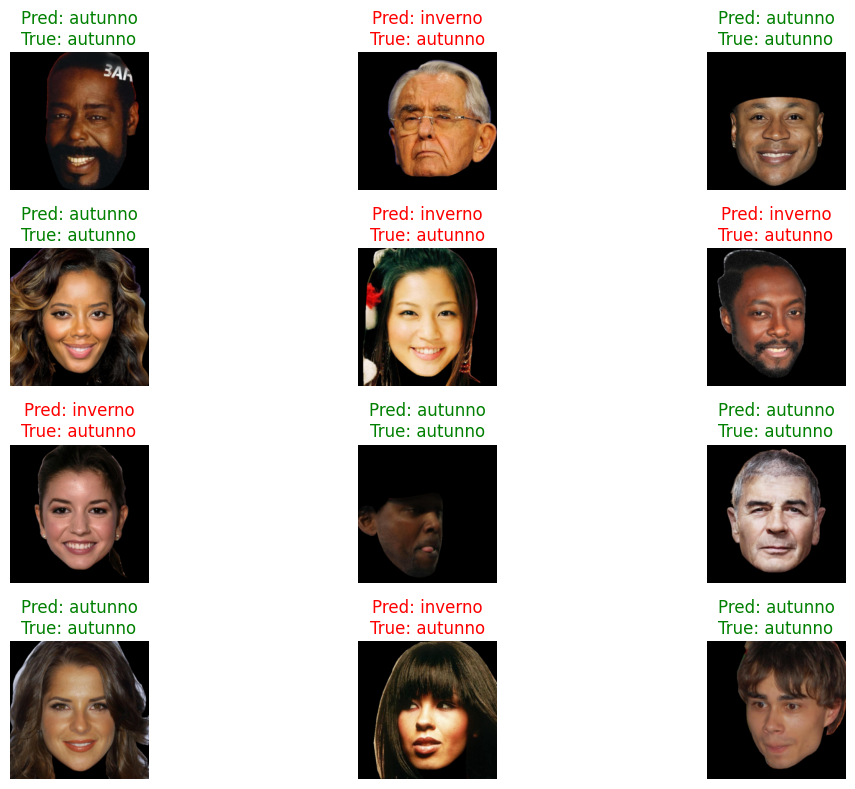

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move to device for prediction
images_cuda = images.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images_cuda)
    _, preds = torch.max(outputs, 1)

# Plot the first 6 images
num_images = 12
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    # Convert Tensor to numpy array and transpose to (H, W, C)
    img = images[i].numpy().transpose((1, 2, 0))
    # Ensure values are valid for plotting (0-1)
    img = np.clip(img, 0, 1)

    ax.imshow(img)

    pred_label = class_names[preds[i]]
    true_label = class_names[labels[i]]

    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()